In [12]:
import numpy as np
import numpy.linalg as nla
import scipy as sp
import control as cntr
import matplotlib.pyplot as plt
import sympy as syp
syp.init_printing()

In [13]:
plt.rcParams.update({
    "font.size": 14,
    "ytick.labelsize": 14,
    "xtick.labelsize": 14
})

# Simulation des PT3-Gliedes

Ansatz Übertragungsfunktion mit 3 Polen, bei -1, -2, -3:

In [14]:
G = cntr.zpk([], [-1, -2, -3], 3)
G

TransferFunction(array([3.]), array([ 1.,  6., 11.,  6.]))

Sprungantwort

In [15]:
t, y = cntr.step_response(G)
plt.plot(t, y)
plt.xlabel("t (s)")
plt.ylabel("$\eta$")
plt.grid()
plt.savefig("pt3_step_response.pdf", bbox_inches="tight")

Zustandsdarstellung in Regelungsform (hier mit Integratorkette von $x_3 \to x_1$)

In [16]:
sys = cntr.tf2ss(G)
sys


StateSpace(array([[ -6., -11.,  -6.],
       [  1.,   0.,   0.],
       [  0.,   1.,   0.]]), array([[1.],
       [0.],
       [0.]]), array([[0., 0., 3.]]), array([[0.]]))

Manuelle Aufstellung der zugehörigen Übertragungsfunktion durch Festlegung von
$x_1 := \eta$, $x_2 := \dot \eta$, $x_3 := \ddot \eta$

In [17]:
sys = cntr.ss([[0, 1, 0], [0, 0, 1], [-6, -11, -6]], [0, 0, 3], [1, 0, 0], 0)
sys

<LinearIOSystem:sys[11]:['u[0]']->['y[0]']>

Eigenwertplatzierung

In [18]:
k = cntr.acker(sys.A, sys.B, [-1.0, -1.0, -1.0])
k

array([[-1.66666667, -2.66666667, -1.        ]])

Kontrolle Lage der Eigenwerte (mehrfache Eigenwerte manchmal problematisch)

In [19]:
ARes = sys.A - sys.B*k
eig, trans = sp.linalg.eig(ARes)
eig

array([-1.00000449+7.78197545e-06j, -1.00000449-7.78197545e-06j,
       -0.99999101+0.00000000e+00j])

Simulation geschlossener Kreis

In [20]:
t, y, x = cntr.initial_response(cntr.StateSpace(ARes, np.zeros_like(sys.B), sys.C, 0), T=12, X0=[3, 0, 0], return_x=True)

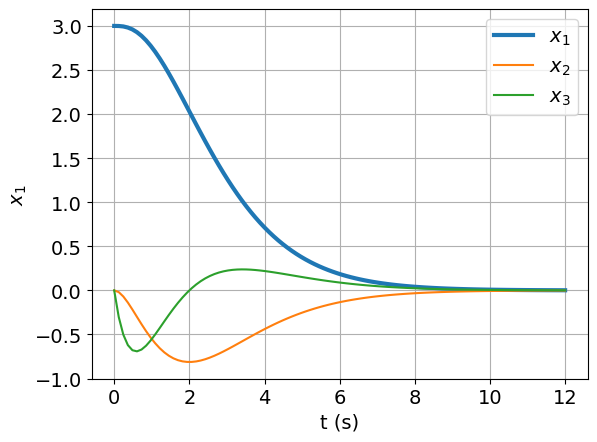

In [21]:
h_lines = plt.plot(t, x[0], t, x[1], t, x[2])
h_lines[0].set_linewidth(3)
plt.grid()
plt.legend(["$x_1$", "$x_2$", "$x_3$"])
plt.xlabel("t (s)")
plt.ylabel("$x_1$")
plt.savefig("linear_state_feedback.pdf", bbox_inches="tight")

Definition einer Klasse für die Berechnung von Solltrajektorien

In [22]:
class RefTraj(object):
    """
    Realisierung verschiedener Arten von Referenztrajektorien
    """

    def __init__(self):
        self.t_start = 0.0
        self.delta_t = 0.0
        self.y_0 = 0.0
        self.y_1 = 1.0
        self.c = np.zeros(6)
        self.type = 'const'  # 'const', 'step', 'poly', 'cosinus'

    def define_const(self, val):
        """"
        Konstanter Wert val wird dauerhaft gehalten.
        """
        self._set('const', 0.0, 0.0, val, 0.0)

    def define_step(self, val1, val2, t_step):
        """
        Sprung von val1 auf val2 zum Zeitpunkt t_step
        """
        self._set('step', t_step, 0.0, val1, val2)

    def define_poly(self, val1, val2, t_start, delta_t):
        """
        Polynomialer Übergang von val1 nach val2 auf Zeitinterval delta_t,
        startend zum Zeitpunkt t_start. 3x stetig diffbar
        """
        self._set('poly', t_start, np.maximum(0.1, delta_t), val1, val2)

        # Koeffizienten des Polynoms bestimmen
        c = np.zeros([8])
        c[0] = val1
        tmatr = self._build_tmatrix(delta_t, 4, 8)
        c[4:8] = nla.solve(tmatr[:, 4:8], np.array([val2 - val1, 0, 0, 0]))
        self.c = c

    def define_cosinus(self, val1, val2, t_start, delta_t):
        """
        Übergang von val1 nach val2 auf Zeitinterval delta_t, startend zum Zeitpunkt
        t_start, repräsentiert durch Cosinus-Segment. Nur 1x stetig diffbar
        """
        self._set('cosinus', t_start, np.maximum(0.1, delta_t), val1, val2)

    def eval(self, t: float) -> np.ndarray:
        """
        Berechnung des Sollwertes und der drei ersten Zeitableitungen zum Zeitpunkt t
        :return: [y_ref, y_ref_dot, y_ref_ddot, y_ref_dddot]
        """
        if self.type == 'const':  # Konstantwert
            return np.array([self.y_0, 0, 0, 0])

        elif self.type == 'step':  # Sprung
            return np.array([self.y_0, 0, 0, 0]) if t < self.t_start else np.array([self.y_1, 0, 0, 0])

        elif self.type == 'poly':  # Polynomialer Übergang
            if t < self.t_start:
                return np.array([self.y_0, 0, 0, 0])
            elif t <= self.t_start + self.delta_t:
                tmatr = self._build_tmatrix(t - self.t_start, 4, 8)
                return np.dot(tmatr, self.c)
            else:
                return np.array([self.y_1, 0, 0, 0])

        elif self.type == 'cosinus':  # Cosinussegment
            if t < self.t_start:
                return np.array([self.y_0, 0, 0, 0])
            elif t <= self.t_start + self.delta_t:
                ampl = 0.5 * (self.y_1 - self.y_0)
                f = np.pi / self.delta_t
                ft = f * (t - self.t_start)
                return np.array([ampl * (1 - np.cos(ft)), ampl * f * np.sin(ft),
                                    ampl * f ** 2 * np.cos(ft), -ampl * f ** 3 * np.sin(ft)])
            else:
                return np.array([self.y_1, 0, 0, 0])

        else:
            raise RuntimeError("Unbekannter Referenztrajektorientyp {}!".format(self.type))

    def _set(self, traj_type, t_start, delta_t, y_0, y_1):
        self.t_start = t_start
        self.delta_t = delta_t
        self.y_0 = y_0
        self.y_1 = y_1
        self.type = traj_type

    @staticmethod
    def _build_tmatrix(t, n, m):
        """ Eine n x m Matrix der folgenden Struktur aufbauen

                |1     t    t**2    t**3    ...                t**(m-1)|
                |0     1    2*t     3*t**2  ...          (m-1)*t**(m-2)|
                |0     0    2*1     3*2*t   ...    (m-1)*(m-2)*t**(m-3)|
                |...                                                ...|

        """
        # p = [1, 2, 3, 4, 5, 6, 7, ...]
        p = np.linspace(1, m, m)

        # Matrix allokieren
        t_matrix = np.zeros((n, m))

        # Erste Zeile [1, t, t**2, t**3, t**4, ...]
        t_matrix[0, 0] = 1.0
        for j in np.arange(1, m):
            t_matrix[0, j] = t_matrix[0, j - 1] * t

        # Nachfolgende Zeilen konstruieren, ergeben sich aus der Ableitung
        # der vorangegangenen + Versatz nach links
        for i in np.arange(1, n):
            t_matrix[i, i:m] = t_matrix[i - 1, i - 1:m - 1] * p[i - 1:m - 1]

        return t_matrix

In [23]:
yRef = RefTraj()
yRef.define_poly(0.0, 2.0, 1.0, 5.0)
t = np.linspace(0, 10, 100)
u = np.zeros_like(t)
y = np.zeros_like(t)
for i, t_step in enumerate(t):
    y[i], yd, ydd, yddd = yRef.eval(t_step)
    u[i] = (yddd + 6 * ydd * 11 * yd + 6 * y[i]) / 3.0

fig, ax1 = plt.subplots()
hline1, = ax1.plot(t, u, color="g", label="Eingang $u$")
ax1.set_ylabel("$u$", color="g")
ax1.tick_params(axis="y", labelcolor="g")
ax1.grid()

ax2 = ax1.twinx()
hline2, = ax2.plot(t, y, label="Ausgang (Vorgabe) $\eta$", color="r", linestyle="dashed")
ax2.set_ylabel("$\eta$", color=hline2.get_color())
ax2.tick_params(axis="y", labelcolor=hline2.get_color())
ax1.legend(loc="lower right", handles=[hline1, hline2])

plt.savefig("linsys_vorsteuerung.pdf", bbox_inches="tight")

# Simulation des PD-PT3-Gliedes

In [24]:
G = cntr.zpk([-1.5], [-1, -2, -3], 3)
G

TransferFunction(array([3. , 4.5]), array([ 1.,  6., 11.,  6.]))

In [25]:
t, y = cntr.step_response(G)
plt.plot(t, y)
plt.xlabel("t (s)")
plt.ylabel("$\eta$")
plt.grid()
plt.savefig("pdpt3_step_response.pdf", bbox_inches="tight")

Zustandsdarstellung in Regelungsform (hier mit Integratorkette von $x_3 \to x_1$)

In [26]:
sys = cntr.tf2ss(G)
sys


StateSpace(array([[ -6., -11.,  -6.],
       [  1.,   0.,   0.],
       [  0.,   1.,   0.]]), array([[1.],
       [0.],
       [0.]]), array([[0. , 3. , 4.5]]), array([[0.]]))

Manuelle Aufstellung der zugehörigen Übertragungsfunktion durch Festlegung von
$x_1 := \eta$, $x_2 := \dot \eta$, $x_3 := \ddot \eta$

In [27]:
sys = cntr.ss([[0, 1, 0], [0, 0, 1], [-6, -11, -6]], [0, 0, 1], [4.5, 3.0, 0], 0)
sys

<LinearIOSystem:sys[17]:['u[0]']->['y[0]']>

Eigenwertplatzierung

In [28]:
k = cntr.acker(sys.A, sys.B, [-1.0, -1.0, -1.0])
k

array([[-5., -8., -3.]])

Kontrolle Lage der Eigenwerte (mehrfache Eigenwerte manchmal problematisch)

In [29]:
ARes = sys.A - sys.B*k
eig, trans = sp.linalg.eig(ARes)
eig

array([-1.00000449+7.78197545e-06j, -1.00000449-7.78197545e-06j,
       -0.99999101+0.00000000e+00j])

Simulation geschlossener Kreis

In [30]:
t, y, x = cntr.initial_response(cntr.StateSpace(ARes, np.zeros_like(sys.B), sys.C, 0), T=12, X0=[3, 0, 0], return_x=True)

In [31]:
fig, ax1 = plt.subplots()
hline1, = ax1.plot(t, x[0], linewidth=3, label="Vorgabe $x_1$")
hline2, = ax1.plot(t, x[1], label="$x_2$")
hline3, = ax1.plot(t, x[2], label="$x_3$")
ax2 = ax1.twinx()
hline4, = ax2.plot(t, 4.5*x[0] + 3.0*x[1], color="r", linestyle="dashed", label="Ausgang $\eta$")
ax1.set_ylim(-1.0, 3.5)
ax1.grid()
ax1.legend(loc="upper right", handles=[hline1, hline2, hline3, hline4])
ax1.set_xlabel("t (s)")
ax1.set_ylabel("$x_1$, $x_2$, $x_3$")
ax1.axhline(0.0, color="k")

ax2.set_ylim(-2.0, 16.0)
ax2.spines["right"].set_color(hline4.get_color())
ax2.set_ylabel("$\eta$", color=hline4.get_color())
ax2.tick_params(axis="y", labelcolor=hline4.get_color())
ax2.axhline(0.0, color=hline4.get_color())
plt.savefig("linear_state_feedback2.pdf", bbox_inches="tight")

Beobachtung: Alle Zustandsgrößen nehmen den Wert 0.0 an, so wie geplant. Der Ausgang macht etwas vollkommen anderes. Das ist aber auch in Ordnung, da man sich beim Entwurf der Zustandsrückführung um den Ausgang gar nicht gekümmert hat.

Nun Entwurf der Vorsteuerung mit dem flachen Ausgang $y = x_1$ und dem Systemausgang $\eta$:

In [32]:
yRef = RefTraj()
yRef.define_poly(0.0, 2.0, 1.0, 5.0)
t = np.linspace(0, 10, 100)
u = np.zeros_like(t)
y = np.zeros_like(t)
eta = np.zeros_like(t)
for i, t_step in enumerate(t):
    y[i], yd, ydd, yddd = yRef.eval(t_step)
    u[i] = (yddd + 6 * ydd * 11 * yd + 6 * y[i])
    eta[i] = 4.5 * y[i] + 3.0 * yd

fig, ax1 = plt.subplots()
hline1, = ax1.plot(t, u, color="g", label="Eingang $u$")
ax1.set_ylabel("$u$", color=hline1.get_color())
ax1.tick_params(axis="y", labelcolor=hline1.get_color())
ax1.grid()

ax2 = ax1.twinx()
hline2, = ax2.plot(t, y, label="Vorgabe $x_1$")
hline3, = ax2.plot(t, eta, label="Ausgang $\eta$", linestyle="dashed", color="r")
ax2.set_ylabel("$\eta$, $x_1$")
ax2.tick_params(axis="y")
ax1.legend(loc="right", handles=[hline1, hline2, hline3])

plt.savefig("linsys_vorsteuerung2.pdf", bbox_inches="tight")

Beobachtung: Der Ausgang $\eta$ macht "irgendwas". Das ist klar, denn man hat nur für $y = x_1$ geplant und $\eta$ hängt dummerweise sowohl von $x_1 = y$ als auch von $x_2 = \dot y$ ab.

## Bestimmung des flachen Ausgangs über Steuerbarkeitsmatrix

In [38]:
A = np.array([[0, 1, 0], [0, 1, 2], [0, 1, 1]])
# A = np.array([[0, 1, 0], [0, 1, 2], [0, 0, -1]])
B = np.array([[0], [1], [1]])
# B = np.array([[0], [1], [0]])
C = np.array([1, 0, 0])

In [49]:
A

array([[0, 1, 0],
       [0, 1, 2],
       [0, 1, 1]])

In [39]:
S = np.hstack([B, A @ B, A**2 @ B])
S

array([[0, 1, 1],
       [1, 3, 5],
       [1, 2, 2]])

In [40]:
np.linalg.matrix_rank(S)

3

In [41]:
Sinv = np.linalg.inv(S)
Sinv

array([[-2. ,  0. ,  1. ],
       [ 1.5, -0.5,  0.5],
       [-0.5,  0.5, -0.5]])

In [42]:
qT = Sinv[2,:]
qT

array([-0.5,  0.5, -0.5])

In [43]:
T = np.vstack([qT, qT @ A, qT @ A**2])
T

array([[-0.5,  0.5, -0.5],
       [ 0. , -0.5,  0.5],
       [ 0. , -0.5,  1.5]])

In [44]:
x1_sym, x2_sym, x3_sym = syp.symbols(["x_1", "x_2", "x_3"])

In [45]:
x_sym = syp.Matrix([x1_sym, x2_sym, x3_sym])
x_sym

In [46]:
T * x_sym

In [47]:
y, y_dot, y_ddot = syp.symbols(["y", "\dot{y}", "\ddot{y}"])
y_vec = syp.Matrix([y, y_dot, y_ddot])
y_vec


Zwischen den Originalkoordinaten $(x_1, x_2, x_3)$ und den Koordinaten $(x_{1R}, x_{2R}, x_{3R})$ in Regelungsnormalform gilt:

\begin{equation*}
    \begin{pmatrix} 
        x_1 \\x_2 \\ x_3 
    \end{pmatrix}
    = T^{-1} \cdot 
    \begin{pmatrix} 
        x_{1R} \\x_{2R} \\ x_{3R} 
    \end{pmatrix}
\end{equation*}

Da für den flachen Ausgang gilt: $y = x_{1R}$ und $\dot x_{1R} = \dot y = x_{2R}$ sowie $\dot x_{2R} = x_{3R} = \ddot y$ gilt für den Zusammenhang zwischen $x_1, x_2, x_3$ und $y, \dot y, \ddot y$:

\begin{equation*}
    \begin{pmatrix} 
        x_1 \\x_2 \\ x_3 
    \end{pmatrix}
    = T^{-1} \cdot 
    \begin{pmatrix} 
        y \\ \dot y \\ \ddot y
    \end{pmatrix}
\end{equation*}

In [48]:
x_on_y = np.linalg.inv(T) @ y_vec
x_on_y

In [51]:
AR = T @ A @ np.linalg.inv(T)
BR = T @ B

In [54]:
AR

array([[ 0. ,  1. ,  0. ],
       [ 0. ,  0.5, -0.5],
       [ 0. , -3.5,  1.5]])